In [1]:
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Import Data

In [4]:
data = pd.read_csv('./dataset/emails.csv')

In [5]:
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,clicked
0,8,short_email,generic,9,Thursday,US,3,0
1,33,long_email,personalized,6,Monday,US,0,0
2,46,short_email,generic,14,Tuesday,US,3,0
3,49,long_email,personalized,11,Thursday,US,10,0
4,65,short_email,generic,8,Wednesday,UK,3,0


When we talk about personalization and data science, the first thing that comes to the mind is Netflix-like personalization. I.e. given that you enjoyed these movies, we think you might like these other movies. Despite the fact that that’s the kind of personalization people tend to talk about the most, in the reality it is just a small subset of the types of personalization data scientists work on, and for sure not the most common.

The most common application of personalization is something that can be well exemplified by the email dataset we worked on in the insight section.
Extracting insights has helped us understand how each variable impacts the output. So, for instance, we found out that personalized as well as short emails are better, we should send emails on weekdays, etc. However, the fact that on an average short emails are better, doesn’t imply that short emails are better for every user we have. The goal of personalization is to take insights one step further and find the best email characteristics for each user. So a given user will receive a long email, another one a short one, one will receive it in the night, and one in the morning, etc.

The sections below will describe how we can use the email dataset to come up with a personalized email strategy. This is how 90% of personalization is implemented on-line.

Before building the model, we choose to bin the continuous variables. I.e. hour will be binned into 3 groups (morning, afternoon, night) and purchase into the following 4 groups: [=0, between 1 and 3, 4-7, and >7]. We bin mainly to speed up the code, to make the output simpler, and also to remove a bit of noise. However, binning is not strictly required, and if you choose to not bin, the approach is exactly the same. It will just take a bit longer.


In [6]:
data.describe()

,email_id,hour,user_past_purchases,clicked
count,99950.000000,99950.000000,99950.000000,99950.00000
mean,498695.729065,9.059100,3.878559,0.02070
std,289226.115244,4.439618,3.196324,0.14238
min,8.000000,1.000000,0.000000,0.00000
25%,246721.500000,6.000000,1.000000,0.00000
50%,498441.500000,9.000000,3.000000,0.00000
75%,749936.750000,12.000000,6.000000,0.00000
max,999998.000000,24.000000,22.000000,1.00000


In [7]:
data.shape

(99950, 8)

# Data Pre-Processing

In [9]:
#Bin the variables accoding to the rules described above
#Hour
data['hour_binned']=pd.cut(data['hour'], bins=[1,5, 13, 21, 24], include_lowest=True, labels=['night', 'morning', 'afternoon', 'night2'])

In [10]:
data['hour_binned'].value_counts()

morning      60319
night        23152
afternoon    16062
night2         417
Name: hour_binned, dtype: int64

In [11]:
#replace night2 with night
data['hour_binned']=data['hour_binned'].replace('night2', 'night').cat.remove_unused_categories()

In [13]:
#Bin purchases
data['purchase_binned']=pd.cut(data['user_past_purchases'], bins=[0,1, 4, 8, 23], include_lowest=True, right=False, labels=['None', 'Low', 'Medium', 'High'])

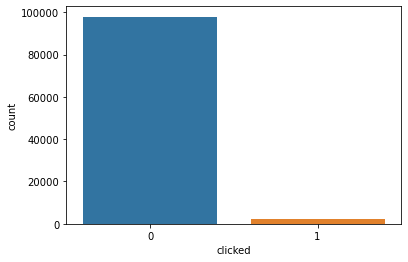

In [12]:
sns.countplot(x='clicked',data=data)

# Model Building

In [14]:
#prepare the data for the model
data_dummy = pd.get_dummies(data, drop_first=True).drop(['email_id', 'hour', 'user_past_purchases'], axis=1)

In [15]:
#split into train and test to avoid overfitting
train, test = train_test_split(data_dummy, test_size = 0.34)

In [16]:
#build the model. We choose a RF, but this personalization approach works with any kinds of models
rf = RandomForestClassifier(class_weight={0:0.05,1:0.95}, n_estimators=50, oob_score=True)
rf.fit(train.drop('clicked', axis=1), train['clicked'])

RandomForestClassifier(class_weight={0: 0.05, 1: 0.95}, n_estimators=50,
                       oob_score=True)

In [17]:
print(pd.DataFrame(confusion_matrix(train['clicked'], rf.oob_decision_function_[:,1].round(), labels=[0, 1])))

       0     1
0  59235  5366
1   1041   325


In [18]:
print(pd.DataFrame(confusion_matrix(test['clicked'], rf.predict(test.drop('clicked', axis=1)), labels=[0, 1])))

       0     1
0  30751  2529
1    557   146


OOB and test error are very similar, so we are confident we are not overfitting. And overall the model is working pretty well. We only had 2% of clicks, but despite that the model is not predicting all events as class 0, we actually manage to predict ~23% of clicks (changing weights helped). And class 0 error didn’t go up that much either, being below 9%.

Predict click-through-rate for each segment

The second step is to create a new dataset with all unique combinations of our variables. We will then feed this dataset into the model and, for each unique combination, we will get a prediction. The model prediction represents click-rate and, therefore, this step is meant to estimate probability of clicking for each unique combination of country, # of purchases, email text, weekday, etc.

In [19]:
#We remove the label, we don't need it here
data_unique = data_dummy.drop(['clicked'], axis=1)
  
#We create all unique combinations of our features
data_unique = data_unique.drop_duplicates()
  
#Now we feed this into our model and get a pre
predictions = rf.predict_proba(data_unique)

In [20]:
predictions

array([[0.73558808, 0.26441192],
       [1.        , 0.        ],
       [0.83832145, 0.16167855],
       ...,
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [21]:
#Finally, we add these predictions to the dataset
data_unique['prediction'] = [x[1] for x in predictions]

In [22]:
data_unique.head()

,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US,hour_binned_morning,hour_binned_afternoon,purchase_binned_Low,purchase_binned_Medium,purchase_binned_High,prediction
0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0.264412
1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0.000000
2,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0.161679
3,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0.725791
4,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0.478043


# Personalization

The third step is to identify the variables that can be personalized. This typically means separating user characteristics from product characteristics, and focus on the second ones. After all, you can choose when to send the email or its message, but you can’t realistically move a customer from Spain to UK.

Then, you group by unique combinations of user characteristics and find the product characteristics with the highest probability of clicking. So, for instance, one group will be US customers with 0 purchases (these are user characteristics). And then we will look for the combination of all the other variables that maximize probability of clicking. And that’s it. That combination will tell us how our product should be for those users and we will send emails accordingly. The more variables you have about your users, the more granular will be the groups and, therefore, the more specific will be the personalization.

In [23]:
#Sort by prediction. This way highest predictions will be at the top of the dataset 
data_unique = data_unique.sort_values('prediction', ascending=False)
  
#Remove duplicates for country and purchase binned. This way, for each unique combination of country and purchase,
#we will only have the top 1 value, which means the highest prediction
best_segment = data_unique.drop_duplicates(subset=['user_country_FR', 'user_country_UK', 'user_country_US', 
                                         'purchase_binned_Low', 'purchase_binned_Medium', 'purchase_binned_High'
                                         ]).copy()

In [24]:
#This is not strictly needed. However, it is pretty hard to read that dataset cause we have all the dummy variables
#So let's reconstruct manually the original categorical varibles. It will be so much clearer that way
#Country
best_segment['user_country'] = np.where(best_segment['user_country_UK'] == 1, "UK", 
                                   np.where(best_segment['user_country_US'] == 1, "US", 
                                      np.where(best_segment['user_country_FR'] == 1, "FR",
                                     "ES"
)))

In [25]:
best_segment = best_segment.drop([e for e in list(data_unique) if e.startswith('user_country_')], axis=1)

In [26]:
#Number_purchases
best_segment['purchase_binned'] = np.where(best_segment['purchase_binned_High'] == 1, "High", 
                                   np.where(best_segment['purchase_binned_Medium'] == 1, "Medium", 
                                    np.where(best_segment['purchase_binned_Low'] == 1, "Low",
                                     "None"
)))
best_segment = best_segment.drop([e for e in list(data_unique) if e.startswith('purchase_binned_')], axis=1)

In [27]:
#Email Text
best_segment['email_text'] = np.where(best_segment['email_text_short_email'] == 1, "short_email", "long_email")
best_segment = best_segment.drop('email_text_short_email', axis=1)

In [28]:
#Email version
best_segment['email_version'] = np.where(best_segment['email_version_personalized'] == 1, "personalized", "generic")
best_segment = best_segment.drop('email_version_personalized', axis=1)

In [29]:
best_segment.head()

,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,hour_binned_morning,hour_binned_afternoon,prediction,user_country,purchase_binned,email_text,email_version
55,0,0,0,0,1,0,1,0,0.755067,ES,High,short_email,personalized
943,0,0,0,0,0,1,0,1,0.750606,UK,High,long_email,generic
3,0,0,0,1,0,0,1,0,0.725791,US,High,long_email,personalized
7361,1,0,0,0,0,0,1,0,0.715544,FR,High,short_email,personalized
3390,0,1,0,0,0,0,0,1,0.675495,UK,Low,short_email,generic


In [30]:
#Weekday
best_segment['weekday'] = np.where(best_segment['weekday_Monday'] == 1, "Monday", 
                                    np.where(best_segment['weekday_Saturday'] == 1, "Saturday", 
                                       np.where(best_segment['weekday_Sunday'] == 1, "Sunday",
                                          np.where(best_segment['weekday_Thursday'] == 1, "Thursday", 
                                              np.where(best_segment['weekday_Tuesday'] == 1, "Tuesday",
                                                   np.where(best_segment['weekday_Wednesday'] == 1, "Wednesday",
                                                      "Friday"
))))))
best_segment = best_segment.drop([e for e in list(data_unique) if e.startswith('weekday_')], axis=1) 

In [31]:
#Hour
best_segment['hour_binned'] = np.where(best_segment['hour_binned_afternoon'] == 1, "afternoon", 
                                   np.where(best_segment['hour_binned_morning'] == 1, "morning", 
                                     "night"
))
best_segment = best_segment.drop([e for e in list(data_unique) if e.startswith('hour_binned_')], axis=1) 

In [32]:
best_segment.head()

,prediction,user_country,purchase_binned,email_text,email_version,weekday,hour_binned
55,0.755067,ES,High,short_email,personalized,Tuesday,morning
943,0.750606,UK,High,long_email,generic,Wednesday,afternoon
3,0.725791,US,High,long_email,personalized,Thursday,morning
7361,0.715544,FR,High,short_email,personalized,Monday,morning
3390,0.675495,UK,Low,short_email,generic,Saturday,afternoon


So now we have a model that returns the best email strategy for each user and that’s how we should be sending email to maximize overall click-through-rate. Btw note how even the best email strategy has super low model predictions for users with no purchases, regardless of the country. Once again, you won’t win those people just by tweaking the email.

Estimate A/B test gains

Now that we have come up with a personalized strategy to send emails, the last step is to test it. In order to test, we would run our personalized algorithm on a randomized fraction of users and compare its results with the current email strategy.

In order to run the test though, we still have to convince our product manager that it makes sense to run the test from a cost-opportunity standpoint. And the best way to do that is giving them an estimate of by how much we think we could potentially increase click-rate. That way they can figure out whether it makes sense.

This is pretty straightforward. Since we know the predicted probability for each group, we can just estimate the weighted average to guess the final overall click-rate. However, there is one caveat:

We cannot simply take the predicted probability from the model. After all, our model is not perfect and had a pretty high class 1 error. There are segments where our model is predicting more than 75%! That’s never going to happen in practice, we will never get 75% clicks. What we need to do is to adjust the predicted probabilities after taking into account the model expected error. That is:

Assume, for instance, that your model output is 0.8, so it is predicting 80% clicks. You know, based on the confusion matrix when you built the model, that when your model predicts class 1 is right 5% of the times and when it predicts class 0 is wrong 2% of the times. So if my model is predicting 80% class 1 (and therefore 20% class 0), am actually expecting:

0.80.05 + 0.20.02 = ~4% clicks, which is not the original 80%, but it would still be a huge improvement if my starting point is 2%!

In [33]:
#First let's get count by group. We need this for the weighted average at the end
count_segment = data[['user_country','purchase_binned']].groupby(['user_country','purchase_binned']).size().reset_index(name='counts')

In [34]:
count_segment.head()

,user_country,purchase_binned,counts
0,ES,None,1368
1,ES,Low,3785
2,ES,Medium,3389
3,ES,High,1422
4,FR,None,1341


In [35]:
#Get the proportion instead of the counts. Just easier to deal with to later get weighted average
count_segment['weight'] = count_segment['counts'].div(count_segment['counts'].sum())

In [36]:
count_segment.head()

,user_country,purchase_binned,counts,weight
0,ES,None,1368,0.013687
1,ES,Low,3785,0.037869
2,ES,Medium,3389,0.033907
3,ES,High,1422,0.014227
4,FR,None,1341,0.013417


In [37]:
#Merge it, so in our final dataset we also have weight
best_segment = pd.merge(best_segment, count_segment).sort_values('prediction',ascending=False)

In [38]:
#Now let's add class1 and class 0 errors to the dataset. We will take it from the test error confusion matrix
conf_matrix = pd.DataFrame(confusion_matrix(test['clicked'], rf.predict(test.drop('clicked', axis=1)), labels=[0, 1]))
  
#We define positive predictive value (ppv) as the proportion of times the model is right when it predicts 1, this is also called precision 
ppv = conf_matrix.loc[1,1]/(conf_matrix.loc[1,1]+conf_matrix.loc[0,1])
  
#We also need false positive rate (FPR). Indeed, those are actual clicks (the model is mistakenly predicting non-click, but it is actually a click)
fpr = conf_matrix.loc[1,0]/(conf_matrix.loc[1,0]+conf_matrix.loc[0,0])
  
#Adjusted predicted click-rate for each segment
best_segment['adjusted_prediction'] = best_segment['prediction'] * ppv + (1-best_segment['prediction']) * fpr
  
#Finally, let's multiply this by the weight of each segment in the dataset and compare it with the starting click-rate
CTR_comparison = pd.DataFrame( {'predicted_click_rate':[(best_segment['adjusted_prediction']*best_segment['weight']).sum()],
                                    'old_click_rate':[data['clicked'].mean()]
                                    })

True Positive Rate(TPR)

Recall

Sensitivity = sum(True Positive)/sum(condition positive) 

Positive predictive value(PPV)

precision = sum(true positive)/sum(predicted condition positive) 

condition positive(P), the number of real positive cases in the data 

condition negative N: the number of real negative cases in the data 

fpr, false psotive rate = sum(false positive)/sum(condition negative)

In [40]:
conf_matrix

,0,1
0,30751,2529
1,557,146


In [39]:
CTR_comparison

,predicted_click_rate,old_click_rate
0,0.037558,0.0207


# Conclusion

So, personalization is expected to beat the old strategy by almost 2X. This is huge. We won’t really know for sure what happens until we run a proper A/B test, but this is more than enough to justify running the test. When you use models to predict what would happen in the real world, always adjust predictions based on the model class errors
If we are used to DS tutorials and/or have never worked on actual data, we might think that the model performance was very bad. Our model precision was ~5%. As matter of fact, that was actually really good. Our starting click-through-rate is 2%. A 5% precision means we have found a region of space with 2.5X probability of clicking. That’s huge when we deal with real data. And, at the end, our overall predicted click-through-rate went from 2% to 3.7%. That’s also huge. It would mean almost doubling up whatever revenue is coming from emails.

Anything higher than that is highly unrealistic and usually happens only when you apply models to some made-up data whose only goal is to make the model predict well.

we can notice that certain segments have very low weight. So that might be a noisy area. This does not impact much our final estimate because we multiplied each group adjusted prediction by their weight. However, often you want to do personalization only if you have at least a certain number of people in your training set